Control Group Summary (Mean with 95% Confidence Intervals):
                              MCI                          MildAD  \
0  100000.0 (100000.0 - 100000.0)                 0.0 (0.0 - 0.0)   
1  72371.39 (67646.72 - 77096.07)  26272.68 (21488.65 - 31056.71)   
2  24036.59 (20103.22 - 27969.97)  72153.05 (68104.99 - 76201.11)   
3      3187.9 (1965.31 - 4410.49)   90206.71 (88924.1 - 91489.33)   
4         248.76 (31.99 - 465.53)   89800.8 (89551.45 - 90050.15)   
5            11.4 (-4.85 - 27.65)  86518.46 (86426.33 - 86610.58)   
6             0.19 (-0.11 - 0.48)  81972.28 (81625.83 - 82318.73)   
7                 0.0 (0.0 - 0.0)  66455.39 (64738.22 - 68172.55)   
8                 0.0 (0.0 - 0.0)  45984.81 (43727.96 - 48241.66)   
9                 0.0 (0.0 - 0.0)  28325.81 (26218.67 - 30432.95)   

                       ModerateAD         SevereAD  \
0                 0.0 (0.0 - 0.0)  0.0 (0.0 - 0.0)   
1                 0.0 (0.0 - 0.0)  0.0 (0.0 - 0.0)   
2                 

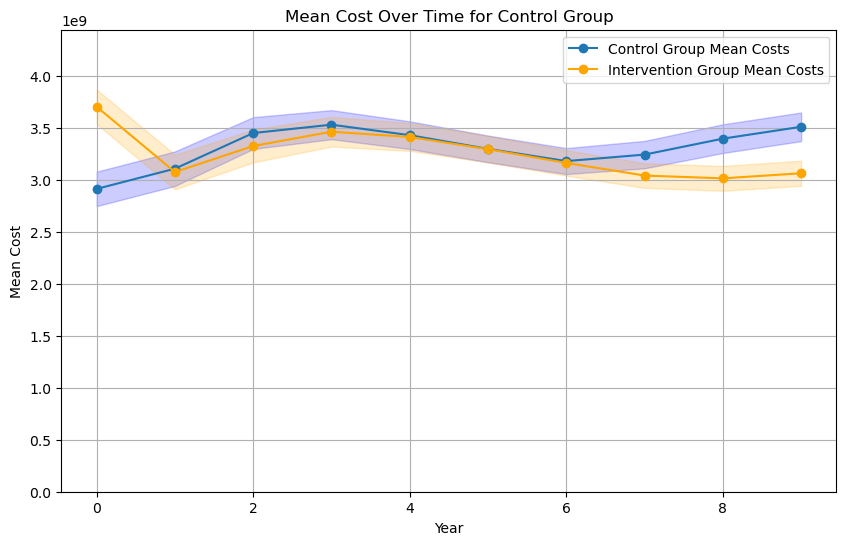

In [152]:
import simpy
import numpy as np
import pandas as pd
import math
from scipy import stats  # Importing the stats module from scipy
import matplotlib.pyplot as plt

# Parameters that must be specified by the user
num_replications = 100  # Specify the number of replications
num_patients = 100000 # Specify the number of patients=10
follow_up_years=10
pMALE = 0.6  # Define the percentage of males

# Parameters for describing the natural history of the disease
CUT_OFF_MILD_AD = 4.5
CUT_OFF_MODERATE_AD = 9.5
CUT_OFF_SEVERE_AD = 16

# Parameters for describing CDR-SB evolution
bB = np.array([5.260005139, 0.57640898700, 0.0089843680, -0.12776127300, -0.16889013300])
C = np.array([
    [0.32734000, -0.00005823586, -0.0064335612, -0.01177737000, 0.00005823586],
    [0.00000000, 0.04102823100, 0.0004554976, -0.00001671691, -0.04102823000],
    [0.00000000, 0.00000000000, 0.0567232474, -0.00102812300, -0.00033606900],
    [0.00000000, 0.00000000000, 0.0000000000, 0.00104080300, -0.00104080300],
    [0.00000000, 0.000000000000, 0.0000000000, 0.00000000000, 0.0410255600]
])
m1 = 0.4973 
m2 = 0.4521

# Parameters describing AD survival
S = np.array([
    [-87.38, 111.8], 
    [3.742, -2.560], 
    [-0.04759, 0.01877], 
    [0.0001903, -0.00004246]
])

# Parameters for defining population's socioeconomic parameters
mean_Age = 72.72
sd_Age = 6.58
mean_bMMSE = 27.30
sd_bMMSE = 2.40
mean_bCDR = 1.70
sd_bCDR = 0.15
alfaMaleTOC = math.exp(-8.92429766221)
betaMaleTOC = 0.075684416915906
alfaFemaleTOC = math.exp(-9.56691291810032)
betaFemaleTOC = 0.079076159880673

# Parameters for obtaining patients' costs
DIAGNOSTIC_TEST_COST = 2900  # Cost of AD disease diagnosis
TRT_COST = 5000  # Annual treatment cost
mean_MCI_COST_STAGE = 29551  # Annual cost of the Mild Cognitive Impairment Stage
sd_MCI_COST_STAGE = 7587
mean_MildAD_COST_STAGE = 38525  # Annual cost of the Mild AD Stage
sd_MildAD_COST_STAGE = 6792
mean_ModerateAD_COST_STAGE = 53920  # Annual cost of the Moderate AD Stage
sd_ModerateAD_COST_STAGE = 8456
mean_SevereAD_COST_STAGE = 74750  # Annual cost of the Severe AD Stage
sd_SevereAD_COST_STAGE = 7878

alfa_MCI_COST_STAGE = mean_MCI_COST_STAGE**2 / sd_MCI_COST_STAGE**2
beta_MCI_COST_STAGE = sd_MCI_COST_STAGE**2 / mean_MCI_COST_STAGE
alfa_MildAD_COST_STAGE = mean_MildAD_COST_STAGE**2 / sd_MildAD_COST_STAGE**2
beta_MildAD_COST_STAGE = sd_MildAD_COST_STAGE**2 / mean_MildAD_COST_STAGE
alfa_ModerateAD_COST_STAGE = mean_ModerateAD_COST_STAGE**2 / sd_ModerateAD_COST_STAGE**2
beta_ModerateAD_COST_STAGE = sd_ModerateAD_COST_STAGE**2 / mean_ModerateAD_COST_STAGE
alfa_SevereAD_COST_STAGE = mean_SevereAD_COST_STAGE**2 / sd_SevereAD_COST_STAGE**2
beta_SevereAD_COST_STAGE = sd_SevereAD_COST_STAGE**2 / mean_SevereAD_COST_STAGE


class Patient:
    def __init__(self, env, id, group, control_group_durations, intervention_group_durations, B, 
                 follow_up_years=10, cloned_parameters=None):
        self.env = env
        self.id = id
        self.group = group
        self.B = B
        self.control_group_durations = control_group_durations
        self.intervention_group_durations = intervention_group_durations
        self.yearly_stage_times = {year: {'MCI': 0, 'MildAD': 0, 'ModerateAD': 0, 'SevereAD': 0, 'Dead': 0} for year in range(10)}
        self.entry_year = env.now  # Track the year in which the patient entered the model
        
        if cloned_parameters is None:
            self.socioeconomic_parameters = self.generate_socioeconomic_parameters()
        else:
            self.socioeconomic_parameters = cloned_parameters
        
        self.onsets = self.generate_disease_stages_onset()
        self.current_stage = 'MCI'
        self.current_age = self.socioeconomic_parameters['ageIn']
        self.alive = True
        
        # Initialize annual stage tracking
        self.yearly_stage_times = {year: {'MCI': 0, 'MildAD': 0, 'ModerateAD': 0, 'SevereAD': 0, 'Dead': 0} for year in range(follow_up_years)}
        
        # Register all patients in MCI at year 0
        self.yearly_stage_times[0]['MCI'] += 1
        
        self.action = env.process(self.run())

    def generate_socioeconomic_parameters(self):
        # Generate socioeconomic parameters
        sex = np.random.choice([0, 1], p=[pMALE, 1-pMALE])
        ageIn = np.random.normal(mean_Age, sd_Age)
        bMMSE = np.random.normal(mean_bMMSE, sd_bMMSE)
        bCDR = np.random.normal(mean_bCDR, sd_bCDR)
        u = np.random.random()

        if sex == 0:
            alfa = alfaMaleTOC
            beta = betaMaleTOC
        else:
            alfa = alfaFemaleTOC
            beta = betaFemaleTOC

        AgeTOC = ageIn + (1 / beta) * np.log(1 - (beta / alfa) * np.log(1 - u) * np.exp(-beta * ageIn))
    
        return {'sex': sex, 'ageIn': ageIn, 'bMMSE': bMMSE, 'bCDR': bCDR, 'AgeTOC': AgeTOC}

    def generate_disease_stages_onset(self):
        ageIn = self.socioeconomic_parameters['ageIn']
        bCDR = self.socioeconomic_parameters['bCDR']
        bMMSE = self.socioeconomic_parameters['bMMSE']
        sex = self.socioeconomic_parameters['sex']
        group = self.group

        b0 = np.random.random() * m1
        b1 = np.random.random() * m2

        B = self.B
        
        AgeTOC = self.socioeconomic_parameters['AgeTOC']
        AgeMildAD = ageIn + ((CUT_OFF_MILD_AD - bCDR - B[0] - B[2] * group - B[3] * bMMSE - b0) / (B[1] + B[4] * group + b1))        
        AgeModerateAD = ageIn + ((CUT_OFF_MODERATE_AD - bCDR - B[0] - B[2] * group - B[3] * bMMSE - b0) / (B[1] + B[4] * group + b1))
        
        if self.group == 1 and self.id < len(self.control_group_durations): # Ensure there is a corresponding control patient
            # For the intervention group modify AgeSevereAD based on the control group duration
            control_duration = self.control_group_durations[self.id]
            AgeSevereAD = AgeModerateAD + control_duration
        else:
            AgeSevereAD = ageIn + ((CUT_OFF_SEVERE_AD - bCDR - B[0] - B[2] * group - B[3] * bMMSE - b0) / (B[1] + B[4] * group + b1))
        
        AgeTAD = AgeMildAD + (S[0, sex] + S[1, sex] * AgeMildAD + S[2, sex] * AgeMildAD**2 + S[3, sex] * AgeMildAD**3)

        # Store Moderate duration for control group
        if self.group == 0:
            self.control_group_durations.append(min(AgeTAD, AgeTOC) - ageIn)
        else:
            self.intervention_group_durations.append(min(AgeTAD, AgeTOC) - ageIn)
        
        return {'AgeMildAD': AgeMildAD, 'AgeModerateAD': AgeModerateAD, 'AgeSevereAD': AgeSevereAD, 'AgeTAD': AgeTAD, 'AgeTOC': AgeTOC}

    def run(self):
        for year in range(1, len(self.yearly_stage_times)):  # Start from year 1
            if not self.alive:
                self.yearly_stage_times[year]['Dead'] += 1
                continue
            
            next_stage_age = min(self.onsets.values())
            if next_stage_age <= self.current_age + 1:
                # Patient transitions within the year
                time_in_current_stage = next_stage_age - self.current_age
                time_in_next_stage = 1 - time_in_current_stage
                self.yearly_stage_times[year][self.current_stage] += time_in_current_stage
                self.current_age = next_stage_age
                
                # Update the current stage and age
                if 'AgeTOC' in self.onsets and self.current_age >= self.onsets['AgeTOC']:
                    self.current_stage = 'Dead'
                    self.alive = False
                elif self.current_age >= self.onsets.get('AgeSevereAD', float('inf')):
                    self.current_stage = 'SevereAD'
                elif self.current_age >= self.onsets.get('AgeModerateAD', float('inf')):
                    self.current_stage = 'ModerateAD'
                elif self.current_age >= self.onsets.get('AgeMildAD', float('inf')):
                    self.current_stage = 'MildAD'
                
                del self.onsets[min(self.onsets, key=self.onsets.get)]
                self.yearly_stage_times[year][self.current_stage] += time_in_next_stage
            else:
                # Patient stays in the same stage for the entire year
                self.yearly_stage_times[year][self.current_stage] += 1
                self.current_age += 1
            
            yield self.env.timeout(1)

def simulate_patients(env, num_patients, follow_up_years):
    control_group = []
    intervention_group = []
    
    control_group_durations = []
    intervention_group_durations = []

    B = bB + C @ np.random.randn(len(bB))  # Example to generate B based on some logic
    
    for i in range(num_patients):
        # Create control patient
        control_patient = Patient(env, i, group=0, control_group_durations=control_group_durations,
                                  intervention_group_durations=intervention_group_durations, B=B)
        control_group.append(control_patient)
        
        # Create intervention patient with cloned parameters
        intervention_patient = Patient(env, i, group=1, control_group_durations=control_group_durations,
                                       intervention_group_durations=intervention_group_durations, B=B,
                                       cloned_parameters=control_patient.socioeconomic_parameters)
        intervention_group.append(intervention_patient)
    
    yield env.all_of([patient.action for patient in control_group + intervention_group])
    return control_group, intervention_group


def calculate_stage_costs():
    random_value = np.random.rand()
    MCI_COST_STAGE = stats.gamma.ppf(random_value, alfa_MCI_COST_STAGE, scale=beta_MCI_COST_STAGE)
    MildAD_COST_STAGE = stats.gamma.ppf(random_value, alfa_MildAD_COST_STAGE, scale=beta_MildAD_COST_STAGE)
    ModerateAD_COST_STAGE = stats.gamma.ppf(random_value, alfa_ModerateAD_COST_STAGE, scale=beta_ModerateAD_COST_STAGE)
    SevereAD_COST_STAGE = stats.gamma.ppf(random_value, alfa_SevereAD_COST_STAGE, scale=beta_SevereAD_COST_STAGE)
    return MCI_COST_STAGE, MildAD_COST_STAGE, ModerateAD_COST_STAGE, SevereAD_COST_STAGE

def calculate_patient_costs(patient, MCI_COST_STAGE, MildAD_COST_STAGE, ModerateAD_COST_STAGE, SevereAD_COST_STAGE):
    costs_per_year = {year: 0 for year in patient.yearly_stage_times}
    for year, stages in patient.yearly_stage_times.items():
        if stages['Dead'] == 1:
            costs_per_year[year] = 0
        else:
            # Add costs for each stage
            costs_per_year[year] += stages['MCI'] * MCI_COST_STAGE
            costs_per_year[year] += stages['MildAD'] * MildAD_COST_STAGE
            costs_per_year[year] += stages['ModerateAD'] * ModerateAD_COST_STAGE
            costs_per_year[year] += stages['SevereAD'] * SevereAD_COST_STAGE
            
            # Add diagnostic cost only in the entry year
            if year == patient.entry_year and patient.group == 1:  # Only for the intervention group
                costs_per_year[year] += DIAGNOSTIC_TEST_COST + stages['MCI'] * TRT_COST

    return costs_per_year

def simulate_patients_with_costs(env, num_patients, follow_up_years=10):
    control_group = []
    intervention_group = []
    
    control_group_durations = []
    intervention_group_durations = []

    # Generate B and costs for this replication
    B = bB + C @ np.random.randn(len(bB))
    MCI_COST_STAGE, MildAD_COST_STAGE, ModerateAD_COST_STAGE, SevereAD_COST_STAGE = calculate_stage_costs()
    
    for i in range(num_patients):
        # Create control patient
        control_patient = Patient(env, i, group=0, control_group_durations=control_group_durations,
                                  intervention_group_durations=intervention_group_durations, B=B)
        control_group.append(control_patient)
        
        # Create intervention patient with cloned parameters
        intervention_patient = Patient(env, i, group=1, control_group_durations=control_group_durations,
                                       intervention_group_durations=intervention_group_durations, B=B,
                                       cloned_parameters=control_patient.socioeconomic_parameters)
        intervention_group.append(intervention_patient)
    
    yield env.all_of([patient.action for patient in control_group + intervention_group])
    
    # Calculate and accumulate costs for control and intervention groups
    total_costs_control = {year: 0 for year in range(follow_up_years)}
    total_costs_intervention = {year: 0 for year in range(follow_up_years)}
    
    for patient in control_group:
        patient_costs = calculate_patient_costs(patient, MCI_COST_STAGE, MildAD_COST_STAGE, ModerateAD_COST_STAGE, SevereAD_COST_STAGE)
        for year, cost in patient_costs.items():
            total_costs_control[year] += cost

    for patient in intervention_group:
        patient_costs = calculate_patient_costs(patient, MCI_COST_STAGE, MildAD_COST_STAGE, ModerateAD_COST_STAGE, SevereAD_COST_STAGE)
        for year, cost in patient_costs.items():
            total_costs_intervention[year] += cost
    
    return control_group, intervention_group, total_costs_control, total_costs_intervention



def aggregate_results(patients, follow_up_years=10):
    aggregated_data = {year: {'MCI': [], 'MildAD': [], 'ModerateAD': [], 'SevereAD': [], 'Dead': []} for year in range(follow_up_years)}
    
    for patient in patients:
        for year in range(follow_up_years):
            for stage in aggregated_data[year]:
                aggregated_data[year][stage].append(patient.yearly_stage_times[year][stage])
    
    return aggregated_data

def calculate_confidence_intervals(sum_data, num_replications, is_cost_data=False):
    mean_data = {year: {} if not is_cost_data else 0 for year in sum_data}
    ci_data = {year: {} if not is_cost_data else 0 for year in sum_data}
    
    for year in sum_data:
        if is_cost_data:
            values = np.array(sum_data[year])
            mean = np.mean(values)
            std_dev = np.std(values)
            margin_of_error = 1.96 * (std_dev / np.sqrt(num_replications))
            
            mean_data[year] = mean
            ci_data[year] = (mean - margin_of_error, mean + margin_of_error)
        else:
            for stage in sum_data[year]:
                values = np.array(sum_data[year][stage])
                mean = np.mean(values)
                std_dev = np.std(values)
                margin_of_error = 1.96 * (std_dev / np.sqrt(num_replications))
                
                mean_data[year][stage] = mean
                ci_data[year][stage] = (mean - margin_of_error, mean + margin_of_error)
    
    return mean_data, ci_data

def format_results(mean_data, ci_data, is_cost_data=False):
    if is_cost_data:
        # Handling cost data where the dictionary has scalar values
        formatted_data = {year: f"{round(mean_data[year], 2)} ({round(ci_data[year][0], 2)} - {round(ci_data[year][1], 2)})"
                          for year in mean_data}
        return pd.DataFrame.from_dict(formatted_data, orient='index', columns=["Cost"])
    else:
        # Handling patient count data where the dictionary has nested structures
        formatted_data = {year: {stage: f"{round(mean_data[year][stage], 2)} ({round(ci_data[year][stage][0], 2)} - {round(ci_data[year][stage][1], 2)})"
                                 for stage in mean_data[year]}
                          for year in mean_data}
        return pd.DataFrame(formatted_data).T

def run_simulation_with_costs(num_patients, num_replications, follow_up_years):
    all_replication_data_control = []
    all_replication_data_intervention = []
    all_costs_control = []
    all_costs_intervention = []
    
    for rep in range(num_replications):
        env = simpy.Environment()
        control_group, intervention_group, total_costs_control, total_costs_intervention = env.run(until=env.process(simulate_patients_with_costs(env, num_patients, follow_up_years=follow_up_years)))
        
        all_replication_data_control.append(aggregate_results(control_group, follow_up_years=follow_up_years))
        all_replication_data_intervention.append(aggregate_results(intervention_group, follow_up_years=follow_up_years))
        all_costs_control.append(total_costs_control)
        all_costs_intervention.append(total_costs_intervention)
    
    # Combine results from all replications for patient numbers
    sum_data_control = {year: {'MCI': [], 'MildAD': [], 'ModerateAD': [], 'SevereAD': [], 'Dead': []} for year in range(follow_up_years)}
    sum_data_intervention = {year: {'MCI': [], 'MildAD': [], 'ModerateAD': [], 'SevereAD': [], 'Dead': []} for year in range(follow_up_years)}
    
    for rep_data in all_replication_data_control:
        for year in range(follow_up_years):
            for stage in sum_data_control[year]:
                sum_data_control[year][stage].append(sum(rep_data[year][stage]))
    
    for rep_data in all_replication_data_intervention:
        for year in range(follow_up_years):
            for stage in sum_data_intervention[year]:
                sum_data_intervention[year][stage].append(sum(rep_data[year][stage]))
    
    # Calculate mean and confidence intervals for patient numbers
    mean_data_control, ci_data_control = calculate_confidence_intervals(sum_data_control, num_replications)
    mean_data_intervention, ci_data_intervention = calculate_confidence_intervals(sum_data_intervention, num_replications)
    
    
    # Format the results into "mean (confidence interval)" for patient numbers
    formatted_control_df = format_results(mean_data_control, ci_data_control)
    formatted_intervention_df = format_results(mean_data_intervention, ci_data_intervention)
    
    # Combine results from all replications for costs
    sum_costs_control = {year: [] for year in range(follow_up_years)}
    sum_costs_intervention = {year: [] for year in range(follow_up_years)}
    
    for costs in all_costs_control:
        for year in range(follow_up_years):
            sum_costs_control[year].append(costs[year])
    
    for costs in all_costs_intervention:
        for year in range(follow_up_years):
            sum_costs_intervention[year].append(costs[year])
    
    # Calculate mean and confidence intervals for costs
    mean_costs_control, ci_costs_control = calculate_confidence_intervals(sum_costs_control, num_replications, is_cost_data=True)
    mean_costs_intervention, ci_costs_intervention = calculate_confidence_intervals(sum_costs_intervention, num_replications, is_cost_data=True)
    
    # Format the results into "mean (confidence interval)" for costs
    formatted_costs_control_df = format_results(mean_costs_control, ci_costs_control, is_cost_data=True)
    formatted_costs_intervention_df = format_results(mean_costs_intervention, ci_costs_intervention, is_cost_data=True)

   
    return mean_costs_control, ci_costs_control, mean_costs_intervention, ci_costs_intervention,  formatted_control_df, formatted_intervention_df, formatted_costs_control_df, formatted_costs_intervention_df

# Run the simulation with costs and patient numbers
mean_costs_control,  ci_costs_control, mean_costs_intervention, ci_costs_intervention, formatted_control_df, formatted_intervention_df, formatted_costs_control_df, formatted_costs_intervention_df = run_simulation_with_costs(num_patients, num_replications, follow_up_years)



# Display the results
print("Control Group Summary (Mean with 95% Confidence Intervals):")
print(formatted_control_df)
print("\nIntervention Group Summary (Mean with 95% Confidence Intervals):")
print(formatted_intervention_df)

print("\nControl Group Costs (Mean with 95% Confidence Intervals):")
print(formatted_costs_control_df)
print("\nIntervention Group Costs (Mean with 95% Confidence Intervals):")
print(formatted_costs_intervention_df)


# Extracting keys (time points) and values (mean costs) from the dictionary
time_points_control = list(mean_costs_control.keys())
mean_costs_control = list(mean_costs_control.values())
ci_lower_control = [ci_costs_control[tp][0] for tp in time_points_control]
ci_upper_control = [ci_costs_control[tp][1] for tp in time_points_control]

time_points_intervention = list(mean_costs_intervention.keys())
mean_costs_intervention = list(mean_costs_intervention.values())
ci_lower_intervention = [ci_costs_intervention[tp][0] for tp in time_points_intervention]
ci_upper_intervention = [ci_costs_intervention[tp][1] for tp in time_points_intervention]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(time_points_control, mean_costs_control, 'o-', label='Control Group Mean Costs')
plt.fill_between(time_points_control, ci_lower_control, ci_upper_control, color='b', alpha=0.2)
plt.plot(time_points_intervention, mean_costs_intervention, 'o-',  color='orange', label='Intervention Group Mean Costs')
plt.fill_between(time_points_intervention, ci_lower_intervention, ci_upper_intervention, color='orange', alpha=0.2)

max_value_control=max(mean_costs_control)
max_value_intervention=max(mean_costs_intervention)
plt.ylim(0, max(max_value_control,max_value_intervention)*1.2)  # max is scaled slightly higher for better visualization

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Mean Cost')
plt.title('Mean Cost Over Time for Control Group')
plt.legend()
plt.grid(True)
plt.show()

